In [50]:
import pandas as pd #импорт библиотек, которые потребуются.
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import Image

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,12)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [51]:
df_churn = pd.read_csv('dataset_Facebook.csv')

In [52]:
df_churn.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,comment,like,share,Total Interactions
0,139441,Photo,2,12,4.0,3,0.0,2752.0,4.0,79.0,17.0,100
1,139441,Status,2,12,3.0,10,0.0,10460.0,5.0,130.0,29.0,164
2,139441,Photo,3,12,3.0,3,0.0,2413.0,0.0,66.0,14.0,80
3,139441,Photo,2,12,2.0,10,1.0,50128.0,58.0,157.0,147.0,1777
4,139441,Photo,2,12,2.0,3,0.0,7244.0,19.0,325.0,49.0,393


In [53]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Page total likes           500 non-null    int64  
 1   Type                       496 non-null    object 
 2   Category                   500 non-null    int64  
 3   Post Month                 500 non-null    int64  
 4   Post Weekday               496 non-null    float64
 5   Post Hour                  500 non-null    int64  
 6   Paid                       497 non-null    float64
 7   Lifetime Post Total Reach  496 non-null    float64
 8   comment                    497 non-null    float64
 9   like                       499 non-null    float64
 10  share                      486 non-null    float64
 11  Total Interactions         500 non-null    int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 47.0+ KB


In [54]:
def preproc(df_init):
    df_preproc = df_init.copy()
    
    df_preproc = df_preproc.drop(['Type'], axis=1)
    
    df_preproc = df_preproc[~df_preproc['Post Weekday'].isnull()]
    df_preproc = df_preproc[~df_preproc['Paid'].isnull()]
    df_preproc = df_preproc[~df_preproc['Lifetime Post Total Reach'].isnull()]
    df_preproc = df_preproc[~df_preproc['comment'].isnull()]
    df_preproc = df_preproc[~df_preproc['like'].isnull()]
    df_preproc = df_preproc[~df_preproc['share'].isnull()]
    
    return df_preproc

In [55]:
df_preproc = df_churn.pipe(preproc) # обрабоатываем датафрейм при помощи функции, описанной выше.
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475 entries, 0 to 498
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Page total likes           475 non-null    int64  
 1   Category                   475 non-null    int64  
 2   Post Month                 475 non-null    int64  
 3   Post Weekday               475 non-null    float64
 4   Post Hour                  475 non-null    int64  
 5   Paid                       475 non-null    float64
 6   Lifetime Post Total Reach  475 non-null    float64
 7   comment                    475 non-null    float64
 8   like                       475 non-null    float64
 9   share                      475 non-null    float64
 10  Total Interactions         475 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 44.5 KB


In [56]:
# разделяем датафрейм на два множества:
# данные для обучения и ответы.
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1].values

In [72]:
from sklearn.model_selection import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

In [99]:
from sklearn.tree import DecisionTreeClassifier #импортируем модель деревьев решений
model = DecisionTreeClassifier(random_state=123) # инициализируем модель

#разбиваем наше множество на 5 частей и перемешиваем "shuffle=True"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

# задаем параметры для валидационной кривой.
# будем исследовать глубину дерева в диапазоне от 1 до 15
train_scores, valid_scores = validation_curve(model, X, y, param_name='max_depth', param_range=range(1, 15), cv=cv, scoring='explained_variance')

/home/forever/Program/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Text(0, 0.5, 'explained_variance')

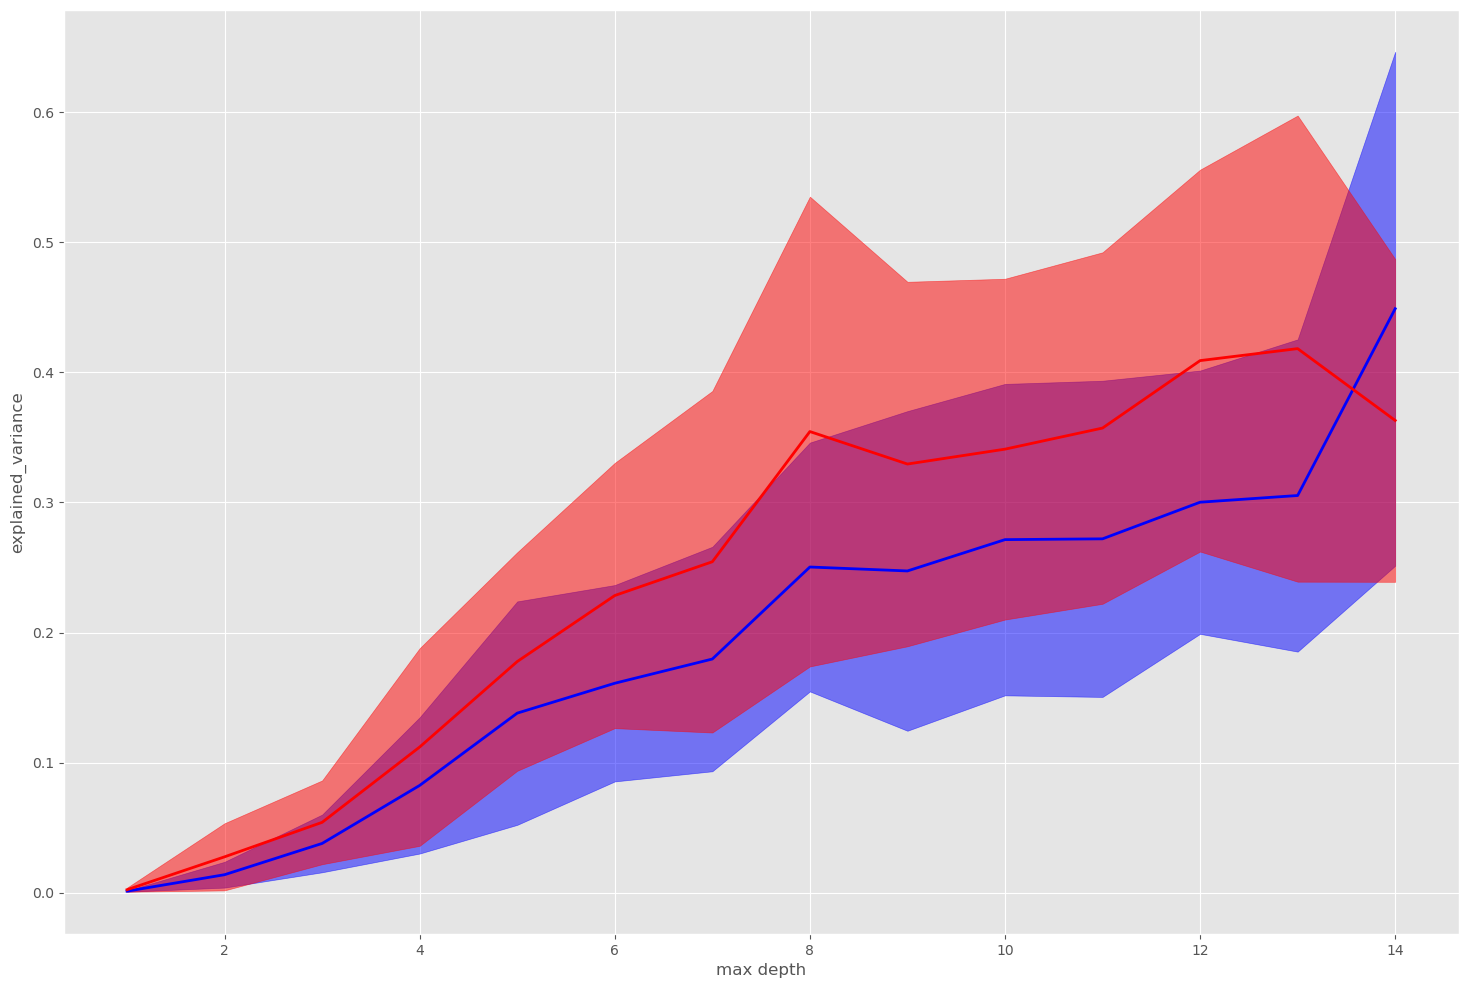

In [128]:
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,15), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,15), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,15), train_score_mean, c='b', lw=2)
plt.plot(range(1,15), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('explained_variance')

In [101]:
try:
    from sklearn.model_selection import RandomizedSearchCV
except ImportError:
    from sklearn.cross_validation import RandomizedSearchCV
    
RND_SEED = 123

In [129]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 8),
    'min_samples_leaf': range(5, 10),
    'class_weight': [None, 'balanced']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, n_jobs=-1,
                                   cv=cv, scoring='explained_variance', random_state=123)

random_search.fit(X, y)

/home/forever/Program/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 8),
                                        'min_samples_leaf': range(5, 10)},
                   random_state=123, scoring='explained_variance')

In [130]:
random_search.best_params_

{'min_samples_leaf': 5,
 'max_depth': 5,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [131]:
random_search.best_score_

0.6517796758009191

In [132]:
best_model = random_search.best_estimator_;
best_model

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       random_state=123)

In [133]:
model = random_search.best_estimator_
imp = model.feature_importances_

In [134]:
pd.Series(index=df_preproc.columns[:-1], data = imp).sort_values()

Page total likes             0.000000
Category                     0.000000
Post Month                   0.000000
Post Hour                    0.000000
Paid                         0.000000
Lifetime Post Total Reach    0.000000
share                        0.000000
comment                      0.166667
Post Weekday                 0.166667
like                         0.666667
dtype: float64